# Лабораторная работа №1 - Динамическая модель многозвенного манипулятора
### Абрамов Максим Витальевич R4134с
### Цель:
> Создать и доопределить модель манипулятора и
 решить задачу обратной динамики.
### Задачи:
 > 1. По выбранному варианту кинематики робота (см. таблицу 2.1)
 загрузить модель манипулятора из программного пакета и
 вывести параметры Денавита-Хартенберга.
 2. Задать массы звеньев, положения их центра масс, тензоры
 инерции, моменты инерции приводов, коэффициенты вязкого
 трения приводов, коэффициенты кулоновского трения приводов, передаточные числа редукторов и ограничения по обобщенным координатам. Рекомендуется обратиться к паспортам
 используемых манипуляторов.
 3. Задать и отобразить произвольные начальную и конечную
 конфигурации робота.
 4. Спланировать траекторию между заданными конфигурация
ми.
 5. Решить обратную задачу динамики методом Ньютона-Эйлера
 для следующих сценариев: 
    - а) ненулевые скорости и ускорения `q'= 0, q''= 0`;
    - б) ненулевые скорости и пренебрежимо малые ускорения `q'=0, q''≈ 0` — квазистатика;
    - в) нулевые скорости и ускорения `q' = 0, q'' = 0` — удержания заданного положения.
 6. Определить численные значения элементов матриц `M(q), C(q,q'), G(q)` в каждый расчетный момент времени.
 7. Построить графики моментов звеньев манипулятора вдоль
 траектории для каждого сценария (см. пункт №5).
 8. Составить отчёт в формате `.ipynb` (см. приложение В)



In [10]:
import numpy as np
import matplotlib.pyplot as plt

from roboticstoolbox import models
import roboticstoolbox as rtb

### 1. По выбранному варианту кинематики робота (см. таблицу 2.1) загрузить модель манипулятора из программного пакета и вывести параметры Денавита-Хартенберга.

In [11]:
# Загрузка модели UR5
robot = models.DH.UR5()

# Вывод DH-параметров
print("Параметры Денавита-Хартенберга:")
for i in range(len(robot.links)):
    print(f"Звено {i}: {robot.links[i]}")

Параметры Денавита-Хартенберга:
Звено 0: RevoluteDH:   θ=q,  d=0.089459,  a=0,  ⍺=1.5707963267948966
Звено 1: RevoluteDH:   θ=q,  d=0,  a=-0.425,  ⍺=0.0
Звено 2: RevoluteDH:   θ=q,  d=0,  a=-0.39225,  ⍺=0.0
Звено 3: RevoluteDH:   θ=q,  d=0.10915,  a=0,  ⍺=1.5707963267948966
Звено 4: RevoluteDH:   θ=q,  d=0.09465,  a=0,  ⍺=-1.5707963267948966
Звено 5: RevoluteDH:   θ=q,  d=0.0823,  a=0,  ⍺=0.0


 ### 2. Задать массы звеньев, положения их центра масс, тензоры инерции, моменты инерции приводов, коэффициенты вязкого трения приводов, коэффициенты кулоновского трения приводов, передаточные числа редукторов и ограничения по обобщенным координатам. Рекомендуется обратиться к паспортам используемых манипуляторов.

In [12]:
# Массы звеньев (кг)
masses = [3.7, 6.8, 4.8, 0.8, 0.8, 0.8]

# Центр масс каждого звена (в локальной системе координат)
centers_of_mass = [
    [0, 0, -0.08],   # Звено 1
    [0, -0.12, 0],   # Звено 2
    [0, 0, -0.12],   # Звено 3
    [0, 0, 0],       # Звено 4
    [0, 0, 0],       # Звено 5
    [0, 0, 0]        # Звено 6
]

# Тензоры инерции (Lxx, Lyy, Lzz, Lxy, Lyz, Lxz)
inertias = [
    [0.0, 0.09, 0.09, 0, 0, 0],         # Звено 1
    [0.23, 0.2, 0.03, 0, 0, 0],         # Звено 2
    [0.02, 0.02, 0.03, 0, 0, 0],        # Звено 3
    [0.001, 0.001, 0.001, 0, 0, 0],     # Звено 4
    [0.001, 0.001, 0.001, 0, 0, 0],     # Звено 5
    [0.001, 0.001, 0.001, 0, 0, 0]      # Звено 6
]

# Момент инерции двигателей (примерно)
Jm = [0.0001, 0.0004, 0.0001, 0.00001, 0.00001, 0.00001]

# Коэффициенты вязкого трения
B = [0.1, 0.1, 0.05, 0.01, 0.01, 0.01]

# Коэффициенты кулоновского трения (±)
Tc = [0.3, 0.5, 0.3, 0.1, 0.1, 0.1]

# Передаточные числа редукторов
G = [100, 100, 100, 50, 50, 50]

# Ограничения по обобщенным координатам (радианы)
qlim = [
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi]
]

# Присвоение динамических параметров каждому звену
for i in range(6):
    robot.links[i].m = masses[i]
    robot.links[i].r = centers_of_mass[i]
    robot.links[i].I = inertias[i]
    robot.links[i].Jm = Jm[i]
    robot.links[i].B = B[i]
    robot.links[i].Tc = Tc[i]
    robot.links[i].G = G[i]
    robot.links[i].qlim = qlim[i]

 ### 3. Задать и отобразить произвольные начальную и конечную конфигурации робота.

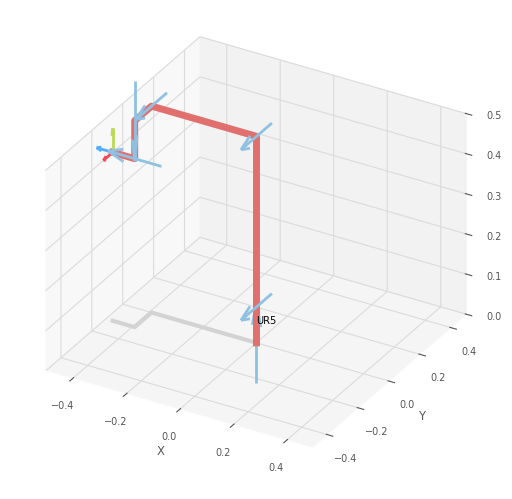

<Figure size 640x480 with 0 Axes>

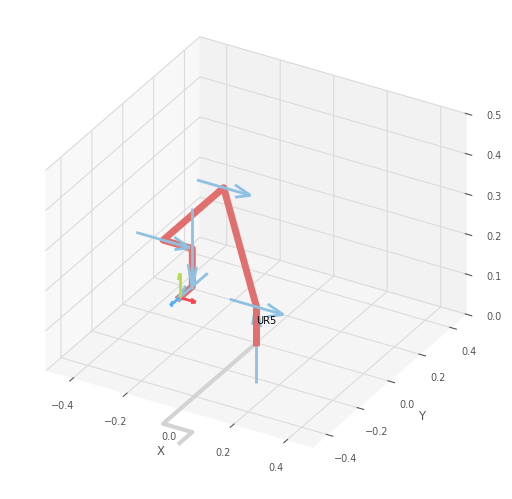

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'UR5')

<Figure size 640x480 with 0 Axes>

In [13]:
# Произвольные начальная и конечная конфигурации
q_start = np.array([0, -np.pi/2, np.pi/2, 0, np.pi/2, 0])
q_end = np.array([np.pi/2, -np.pi/3, np.pi/3, 0, np.pi/2, 0])

# Визуализация начальной и конечной конфигурации
robot.plot(q_start, backend='pyplot', block=False, limits=[-0.5, 0.5, -0.5, 0.5, 0, 0.5])
robot.plot(q_end, backend='pyplot', block=False, limits=[-0.5, 0.5, -0.5, 0.5, 0, 0.5])

 ### 4. Спланировать траекторию между заданными конфигурациями.

In [14]:
# Задание временного массива
timesteps = 50
time = np.linspace(0, 5, timesteps)

# Планирование траектории
traj = rtb.jtraj(q_start, q_end, time)

# Извлечение положений, скоростей и ускорений
q = traj.q
qd = traj.qd
qdd = traj.qdd

 ### 5. Решить обратную задачу динамики методом Ньютона-Эйлера для следующих сценариев:  
   - **а)** ненулевые скорости и ускорения `q' ≠ 0, q'' ≠ 0`;  
   - **б)** ненулевые скорости и пренебрежимо малые ускорения `q' ≠ 0, q'' ≈ 0` — квазистатика;  
   - **в)** нулевые скорости и ускорения `q' = 0, q'' = 0` — удержание заданного положения.  

In [15]:
# Сценарий а: ненулевые скорости и ускорения
tau_a = robot.rne(q, qd, qdd)

# Сценарий б: ненулевые скорости, нулевые ускорения
tau_b = robot.rne(q, qd, np.zeros_like(qdd))

# Сценарий в: нулевые скорости и ускорения
tau_c = robot.rne(q, np.zeros_like(qd), np.zeros_like(qdd))

 ### 6. Определить численные значения элементов матриц `M(q), C(q,q'), G(q)` в каждый расчетный момент времени.

In [16]:
M_list = []
C_list = []
G_list = []

for i in range(timesteps):
    M = robot.inertia(q[i])
    C = robot.coriolis(q[i], qd[i])
    G = robot.gravload(q[i])
    
    M_list.append(M)
    C_list.append(C)
    G_list.append(G)
    
for i in range(timesteps):
    print(f"\nВремя t = {time[i]:.2f} секунд:")
    print(f"M(q) = \n{M_list[i]}")
    print(f"C(q, qd) = \n{C_list[i]}")
    print(f"G(q) = \n{G_list[i]}")


Время t = 0.00 секунд:
M(q) = 
[[ 2.72717550e+00  1.49996676e-01  1.65296760e-02  1.65296760e-02
  -3.32443720e-02 -6.12323400e-20]
 [ 1.49996676e-01  7.74014236e+00  1.14783436e+00 -1.57838320e-02
   3.36744902e-18  6.12323400e-20]
 [ 1.65296760e-02  1.14783436e+00  2.21219636e+00  4.85781680e-02
   1.65404569e-18  6.12323400e-20]
 [ 1.65296760e-02 -1.57838320e-02  4.85781680e-02  4.77524280e-02
   7.26751947e-20  6.12323400e-20]
 [-3.32443720e-02  3.36744902e-18  1.65404569e-18  7.26751947e-20
   3.24186320e-02  6.12323400e-20]
 [-6.12323400e-20  6.12323400e-20  6.12323400e-20  6.12323400e-20
   6.12323400e-20  2.60000000e-02]]
C(q, qd) = 
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
G(q) = 
[-7.88860905e-31 -3.63562524e+01 -2.83512924e+01 -6.45890400e-01
 -7.90987611e-17  0.00000000e+00]

Время t = 0.10 секунд:
M(q) = 
[[ 2.72731144e+00  1.49996676e-01  1.65296760e-02  1.65296760e-02
  -3.32455795e-02

 ### 7. Построить графики моментов звеньев манипулятора вдольтраектории для каждого сценария (см. пункт №5).

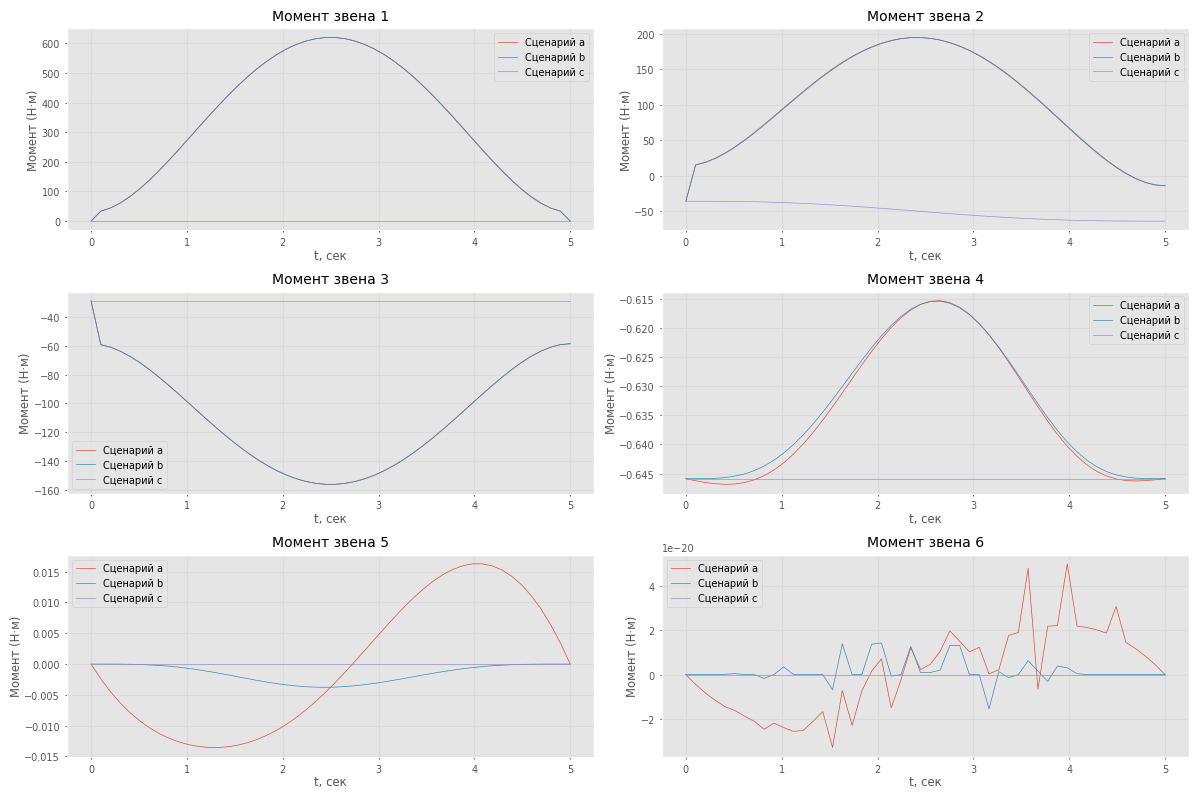

In [18]:
plt.figure(figsize=(12, 8))

for i in range(6):
    plt.subplot(3, 2, i+1)
    plt.plot(time, tau_a[:, i], label='Сценарий a')
    plt.plot(time, tau_b[:, i], label='Сценарий b')
    plt.plot(time, tau_c[:, i], label='Сценарий c')
    plt.title(f'Момент звена {i+1}')
    plt.xlabel('t, сек')
    plt.ylabel('Момент (Н·м)')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

 ## Выводы о проделанной работе:
 > В ходе выполнения лабораторной работы была создана и доопределена динамическая модель многозвенного манипулятора `UR5` на основе параметров Денавита–Хартенберга. Проведено задание физических параметров звеньев, включая массы, положения центров масс, тензоры инерции, а также параметры приводов, такие как моменты инерции, коэффициенты трения и передаточные числа. Для заданных начальной и конечной конфигураций манипулятора была спланирована траектория движения с последующим решением обратной задачи динамики методом Ньютона–Эйлера в различных сценариях: при наличии скоростей и ускорений, в квазистатическом режиме и при удержании заданного положения.
 > 
 > Были получены численные значения составляющих динамической модели — матрицы инерции `M(q)`, центробежных и кориолисовых сил `C(q, q')`, а также гравитационных сил `G(q)`. Построены графики изменения моментов на звеньях вдоль траектории, что позволило проанализировать поведение системы в различных режимах движения. 